In [1]:
import sys
n_runs = 5123
# n_runs = int(sys.argv[1])

In [2]:
oup_mc_fname = '/sdf/scratch/users/d/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_%d.pkl'%(n_runs)
print(oup_mc_fname)

/sdf/scratch/users/d/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_5123.pkl


In [3]:
import matplotlib.pyplot as plt
from tqdm import trange

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

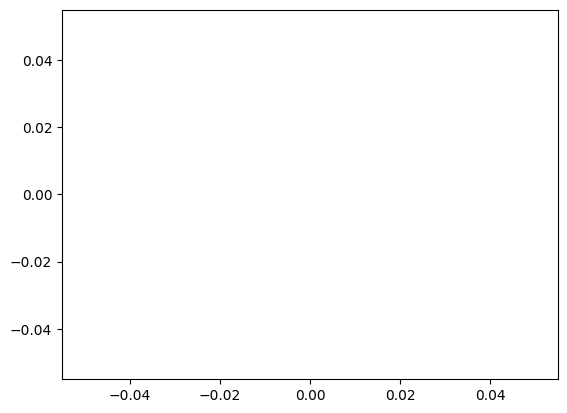

In [4]:
plt.plot()
plt.rcParams.update({
    "text.usetex": False,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

In [5]:
import numpy as np
import pyccl as ccl 

# cosmology
h=0.6736
omch2 = 0.1200
ombh2 = 0.02237
Omc = omch2/h**2
Omb = ombh2/h**2
ns = 0.9649
sigma8 =  0.8111

cosmo = ccl.Cosmology(Omega_c=Omc, Omega_b=Omb,
                          h=h, n_s=ns, sigma8=sigma8)

zstar = 1100
cmbk = ccl.CMBLensingTracer(cosmo, z_source=zstar)

# sampling range
zmax_sample = zstar
amax_sample = 1/(zmax_sample+1)
chimax_sample = ccl.comoving_radial_distance(cosmo, amax_sample)

chis = np.linspace(0, chimax_sample, 10**4)
Wk = cmbk.get_kernel(chis)[0]

a_s = ccl.scale_factor_of_chi(cosmo, chis)
zs = 1/a_s - 1

Dz = ccl.growth_factor(cosmo, a_s)

In [6]:
L = chimax_sample
dchi = jnp.mean(jnp.diff(chis))
ks = 2*jnp.pi*jnp.fft.fftfreq(len(chis), d=dchi)
sort_idx = jnp.argsort(ks)

# power spectrum
P1Dk = ccl.linear_matter_power(cosmo, np.abs(ks), 1)
P1Dk[0] = 0.0 #fix mean
P1Dk = jnp.array(P1Dk)

# set up log space k bins
n_k_bins = 25
k_bin_edges = np.hstack([[0], np.logspace(np.log10(2*jnp.pi/L), np.log10(jnp.pi/dchi), n_k_bins)])
k_bin_edges = jnp.array(k_bin_edges)
k_bin_centers = jnp.sqrt(k_bin_edges[1:]*k_bin_edges[:-1])
bin_indices = jnp.digitize(ks, k_bin_edges) - 1

def count_for_bin(bin_idx):
        return jnp.sum(jnp.where(bin_indices == bin_idx, 1, 0))
bin_counts = jax.vmap(count_for_bin)(jnp.arange(n_k_bins))

# get rid of empty bins

empty_bins = (bin_counts == 0)
non_empty_bins = ~empty_bins
new_k_bin_edges = [k_bin_edges[0]]

new_bin_idx = 0

for i in range(n_k_bins):
    if(non_empty_bins[i]):
        new_k_bin_edges.append(k_bin_edges[i+1])
        new_bin_idx += 1
        
k_bin_edges = jnp.array(new_k_bin_edges)
k_bin_centers = jnp.sqrt(k_bin_edges[1:]*k_bin_edges[:-1])

bin_indices = jnp.digitize(ks, k_bin_edges) - 1
n_k_bins = len(k_bin_edges) - 1
bin_counts = jax.vmap(count_for_bin)(jnp.arange(n_k_bins))

# kernels in fourier space
Kkappa_x = jnp.array(Wk*Dz)
Kkappa_k = jnp.fft.fft(Kkappa_x) * dchi #dchi to put numpy convention to my convention

_KI = (chis-chis[-1])**2 #just a parabola that resembles our LIMs kernel
KI_k = jnp.fft.fft(_KI) * dchi
_KIbar = jnp.mean(_KI) #factor chosen so that large scale <I kappa> roughly same

# which filtering to look at
Lambdas = [0.0, 1e-1]

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)


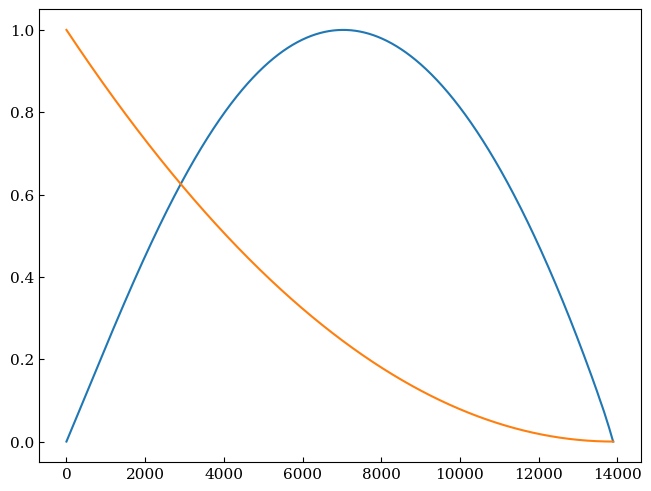

In [7]:
plt.plot(chis, Wk*Dz/np.max(Wk*Dz))
plt.plot(chis, _KI/np.max(_KI))

# Theory spectra for ours and no lightcone

In [8]:
# theory spectra
expected_Ik_kappa = 1/L * jnp.sum((jnp.interp(x = ks.reshape(-1, 1) 
                                              - ks.reshape(1, -1),
                                              xp = ks[sort_idx],
                                              fp = KI_k[sort_idx],
                                              left = 0, right = 0) 
                                   * (Kkappa_k*P1Dk).reshape(1, -1)), 
                                  axis = -1)

expected_kappa2 = jnp.real(1/L * jnp.sum(Kkappa_k * jnp.conj(Kkappa_k) * P1Dk))

@jax.jit
def bin_Ik(i):
    mask =  (bin_indices == i)
    return jnp.sum(jnp.where(mask, expected_Ik_kappa, 0.0)) / jnp.sum(mask)

binned_Ik_kappa = jax.vmap(bin_Ik)(jnp.arange(n_k_bins))

In [9]:
expected_Ik_kappa_noLC = _KIbar*Kkappa_k*P1Dk

@jax.jit
def bin_Ik_noLC(i):
    mask =  (bin_indices == i)
    return jnp.sum(jnp.where(mask, expected_Ik_kappa_noLC, 0.0)) / jnp.sum(mask)

binned_Ik_kappa_noLC = jax.vmap(bin_Ik_noLC)(jnp.arange(n_k_bins))

Text(0, 0.5, '$\\langle I(k)\\kappa\\rangle$')

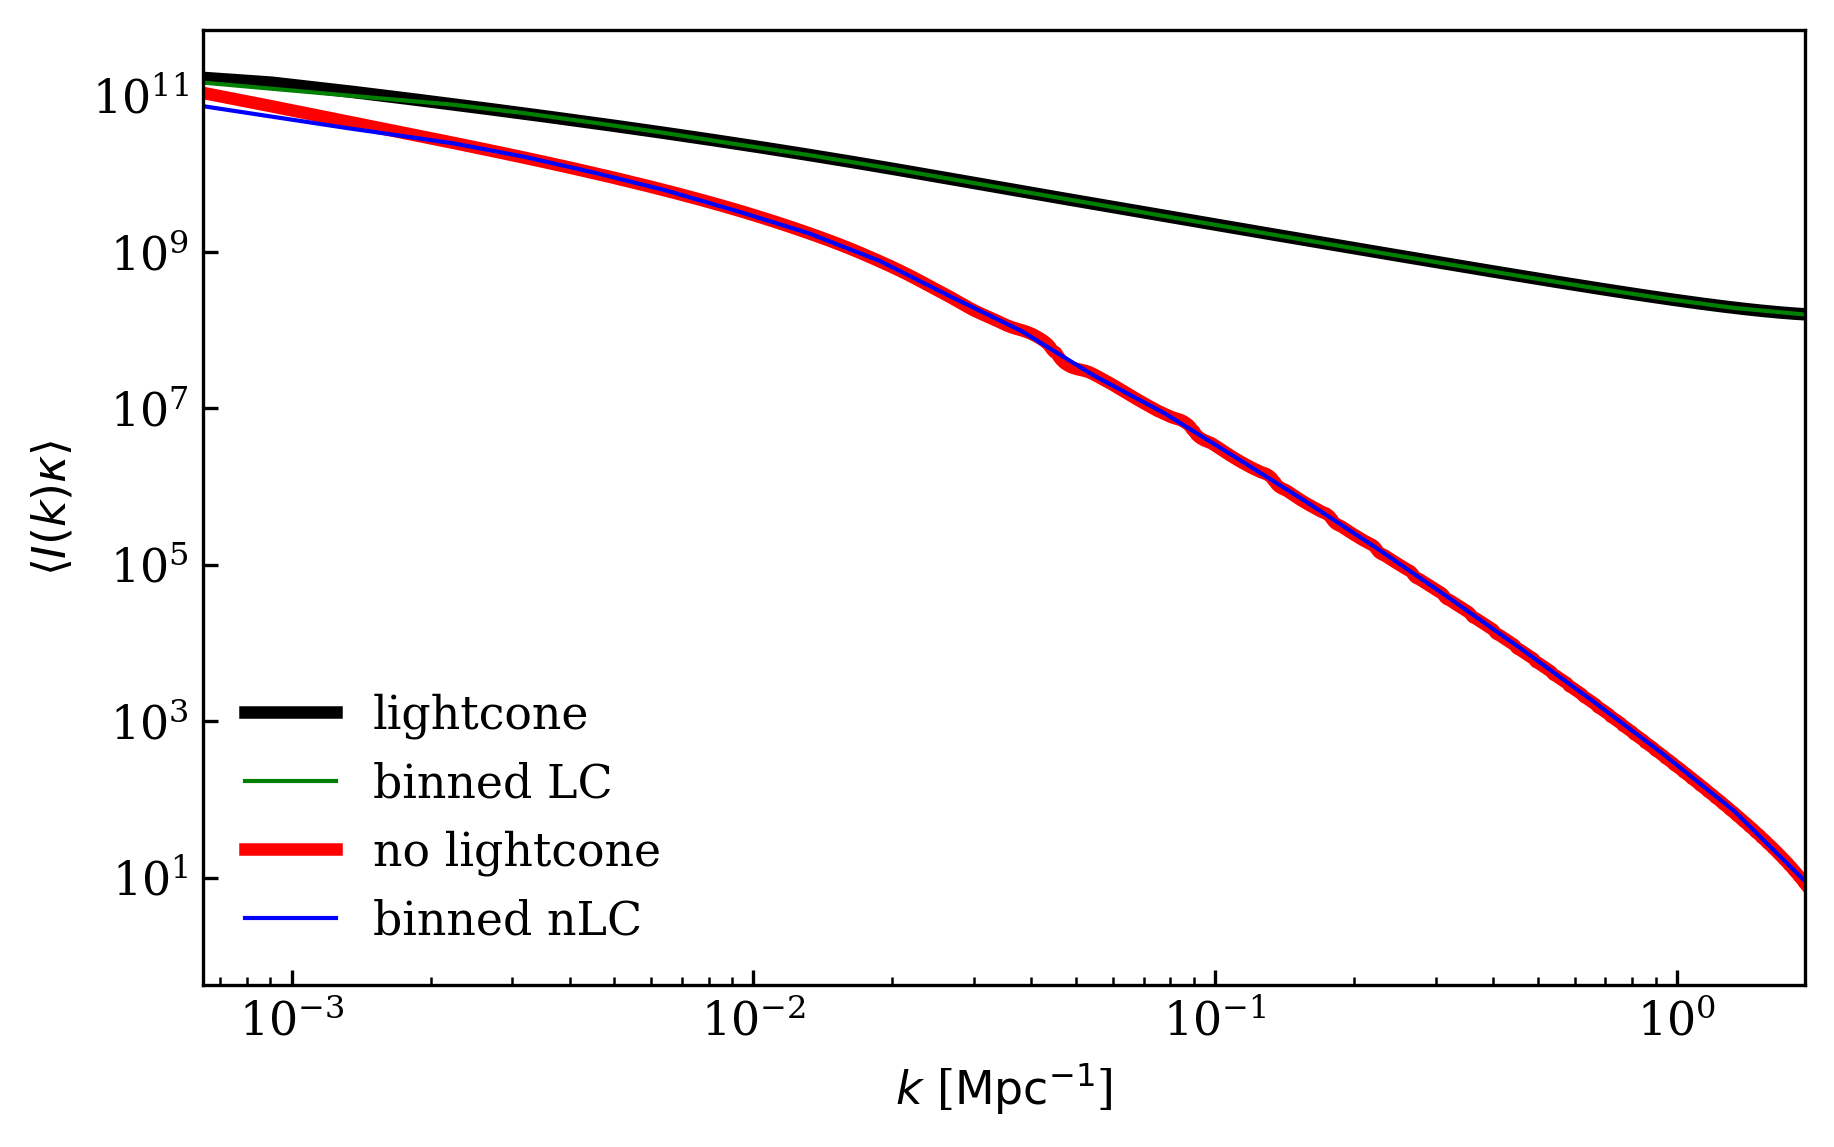

In [10]:
plt.figure(dpi = 300, figsize=(6, 6/1.618), facecolor='w')

plt.plot(ks[sort_idx], jnp.abs(expected_Ik_kappa[sort_idx]), lw = 3, c='k', label='lightcone')

curr_spectra = jnp.abs(binned_Ik_kappa)
# plt.step(k_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
#                  where='post', lw=1, c='g', label='lightcone binned')
# plt.scatter(k_bin_centers, curr_spectra,
#             lw=1, c='g', marker='x')
plt.plot(k_bin_centers, curr_spectra,
            lw=1, c='g', label='binned LC')

plt.plot(ks[sort_idx], jnp.abs(expected_Ik_kappa_noLC[sort_idx]), lw=3, c='r', label='no lightcone')
curr_spectra = jnp.abs(binned_Ik_kappa_noLC)
# plt.step(k_bin_edges, np.append(curr_spectra, [curr_spectra[-1]], ), 
#                  where='post', lw=1, c='b', label='no lightcone binned')
# plt.scatter(k_bin_centers, curr_spectra,
#             lw=1, c='b', marker='x')
plt.plot(k_bin_centers, curr_spectra,
            lw=1, c='b', label='binned nLC')



plt.legend(frameon=False)

plt.loglog()
plt.xlim(k_bin_centers[1], k_bin_centers[-1])

plt.xlabel(r'$k$ [${\sf Mpc}^{-1}$]')
plt.ylabel(r'$\langle I(k)\kappa\rangle$')

In [11]:
# <I I*>
_ks = ks[sort_idx]
_KI_k = KI_k[sort_idx]

interp_q = jnp.interp(
        x= ks.reshape(-1,1) - ks.reshape(1, -1),
        xp=_ks,
        fp=_KI_k,
        left=0, right=0)
@jax.jit
def compute_element(k):
    interp_k = jnp.interp(
        x=k - ks.reshape(1, -1),
        xp=_ks,
        fp=jnp.conj(_KI_k),
        left=0, right=0)
    result = jnp.sum(interp_k * interp_q * P1Dk.reshape(1, -1), axis=-1)
    return result / L
    
expected_II = np.zeros((len(ks), len(ks)), dtype = np.complex128)

for _i in trange(len(ks)):
    _k = ks[_i]
    expected_II[_i] = compute_element(_k)

# <I I*> no LC
expected_II_noLC = L * jnp.diag(_KIbar**2 * P1Dk)

100%|██████████| 10000/10000 [00:52<00:00, 191.17it/s]


In [12]:
cov = expected_kappa2 * expected_II + expected_Ik_kappa.reshape(-1, 1) * jnp.conj(expected_Ik_kappa).reshape(1, -1)
cov_noLC = (expected_kappa2 * expected_II_noLC 
            + expected_Ik_kappa_noLC.reshape(-1, 1) 
            * jnp.conj(expected_Ik_kappa_noLC).reshape(1, -1))

In [13]:
@jax.jit
def bin_cov(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, cov, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
binned_cov = jax.vmap(jax.vmap(bin_cov, in_axes=(None, 0)), in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))

In [14]:
@jax.jit
def bin_cov_noLC(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, cov_noLC, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
binned_cov_noLC = jax.vmap(jax.vmap(bin_cov_noLC, in_axes=(None, 0)), in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))

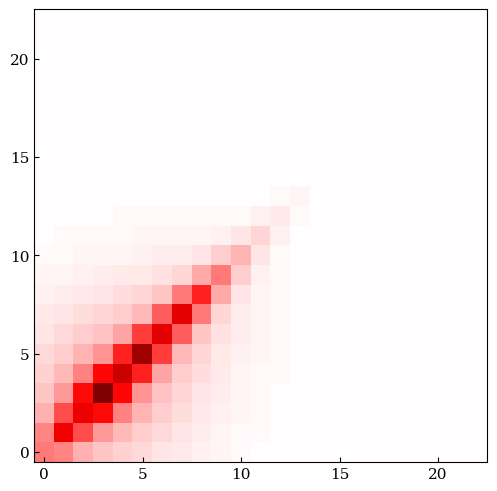

In [15]:
vb = np.max(np.abs(binned_cov))

plt.imshow(jnp.abs(binned_cov), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic')

(0.0, 0.1)

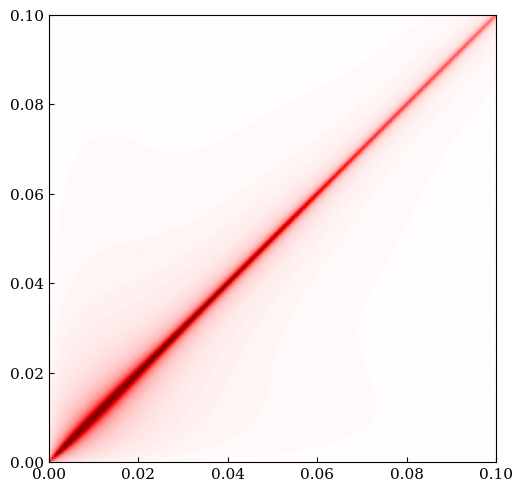

In [16]:
plt.imshow(jnp.abs(cov[sort_idx][:,sort_idx]), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',
          extent=[min(ks), max(ks), min(ks), max(ks)])
plt.xlim(0, 1e-1)
plt.ylim(0, 1e-1)

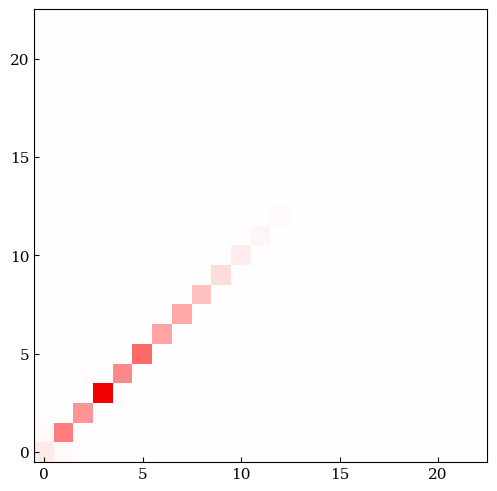

In [17]:
plt.imshow(jnp.abs(binned_cov_noLC), origin='lower',
          vmin = -vb, vmax=vb,cmap='seismic')

(0.0, 0.1)

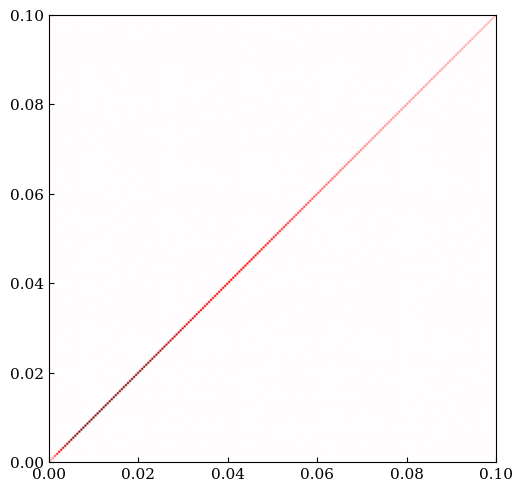

In [18]:
plt.imshow(jnp.abs(cov_noLC[sort_idx][:,sort_idx]), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',
          extent=[min(ks), max(ks), min(ks), max(ks)])
plt.xlim(0, 1e-1)
plt.ylim(0, 1e-1)

# compute SNR

In [19]:
# a couple ways to solve

In [20]:
_L = jnp.linalg.cholesky(binned_cov)
y,_,_,_ = jnp.linalg.lstsq(jnp.conj(_L), jnp.conj(binned_Ik_kappa))
x,_,_,_ = jnp.linalg.lstsq(_L.T, y)
np.dot(binned_Ik_kappa, x)

np.complex128(0.7580158375340331-3.191891195797325e-15j)

In [21]:
x,resid,rank,s = jnp.linalg.lstsq(binned_cov, jnp.conj(binned_Ik_kappa))
SNR2 = binned_Ik_kappa @ x
print(SNR2)

(0.16955484430663673+6.418476861114186e-17j)


In [22]:
x,resid,rank,s = jnp.linalg.lstsq(binned_cov_noLC, jnp.conj(binned_Ik_kappa_noLC))
SNR2_noLC = binned_Ik_kappa_noLC @ x
print(SNR2_noLC)

(0.3327918518549706-2.2379736782924405e-18j)


In [23]:
_binned_cov = np.array(binned_cov)
SNR2s = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], jnp.conj(binned_Ik_kappa[kill_idx:]))
    SNR2s[kill_idx] = jnp.real(binned_Ik_kappa[kill_idx:] @ x)

100%|██████████| 23/23 [00:06<00:00,  3.33it/s]


In [24]:
_binned_cov_noLC = np.array(binned_cov_noLC)
SNR2s_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov_noLC[kill_idx:, kill_idx:], jnp.conj(binned_Ik_kappa_noLC[kill_idx:]))
    SNR2s_noLC[kill_idx] = jnp.real(binned_Ik_kappa_noLC[kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 719.00it/s]


# projected case

In [25]:
# projected
Lambdas = np.hstack(([0],np.array(k_bin_edges[:-1])))

def process_projected(Lambda):
    mask = (jnp.abs(ks) >= Lambda)
    _expected_Ik_projected = 1/L * jnp.sum(jnp.where(mask, 
                                                     (jnp.conj(Kkappa_k) * KI_k * P1Dk), 
                                                     0))
    _expected_II_projected = 1/L * jnp.sum(jnp.where(mask, 
                                                     (jnp.conj(KI_k) * KI_k * P1Dk), 
                                                     0))

    return jnp.array([_expected_Ik_projected, _expected_II_projected])
expected_projected = jnp.zeros((len(Lambdas),2))
expected_projected = jax.vmap(process_projected)(Lambdas)

SNR2s_proj = np.zeros(len(Lambdas))
for LIDX in trange(len(Lambdas)):
    _expected_var_proj = (expected_projected[LIDX,0]*jnp.conj(expected_projected[LIDX,0]) 
                          + expected_kappa2 * expected_projected[LIDX,1])
    SNR2s_proj[LIDX] = jnp.real(expected_projected[LIDX,0]*jnp.conj(expected_projected[LIDX,0]) / _expected_var_proj)

100%|██████████| 24/24 [00:00<00:00, 88.77it/s]


In [26]:
print(SNR2)
print(SNR2_noLC)
print(SNR2s_proj[0])

(0.16955484430663673+6.418476861114186e-17j)
(0.3327918518549706-2.2379736782924405e-18j)
0.05033861511382528


# plot theory SNR

Text(0.5, 0, '$k_{\\sf filter}$ [${\\sf Mpc}^{-1}$]')

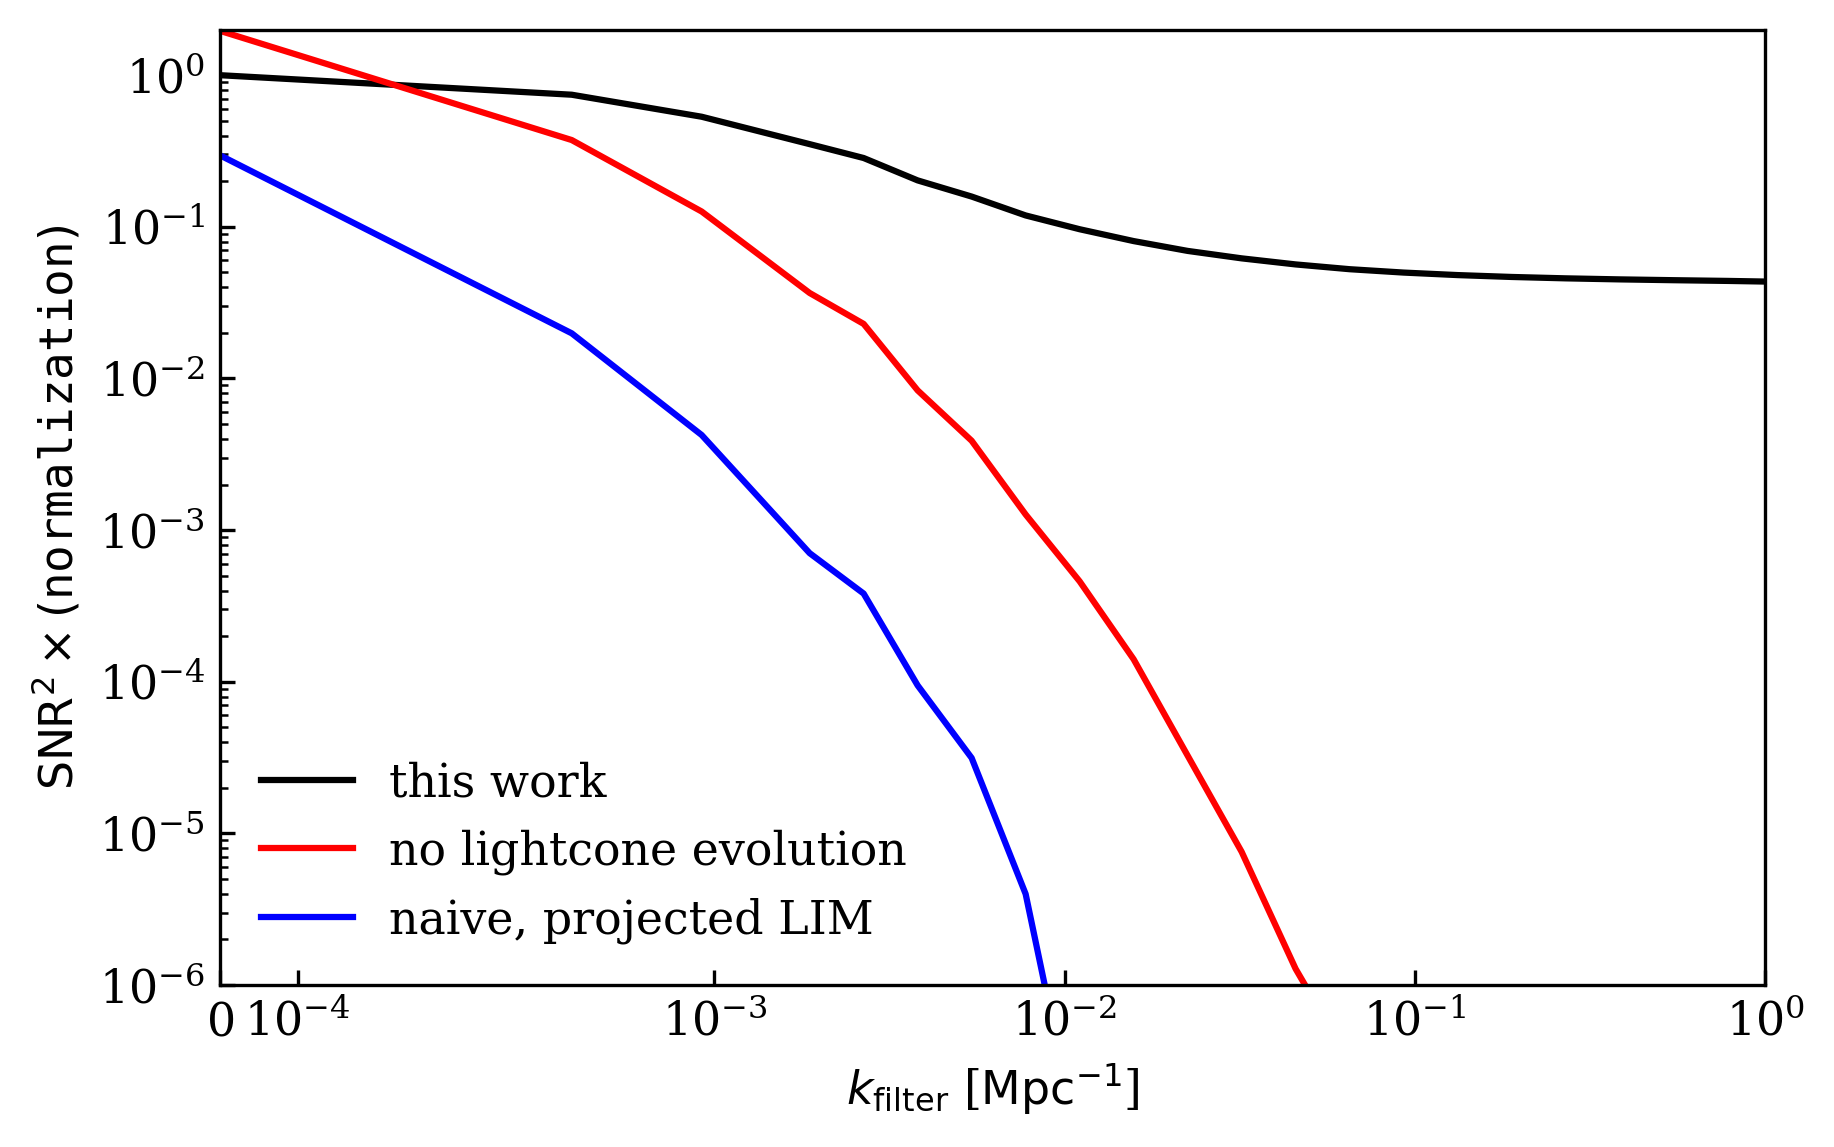

In [27]:
plt.figure(dpi = 300, figsize=(6, 6/1.618), facecolor='w')
plt.plot(k_bin_edges[:-1], SNR2s/SNR2s[0], c='k',  label='this work')
plt.plot(k_bin_edges[:-1], SNR2s_noLC/SNR2s[0], c='r', label='no lightcone evolution')
plt.plot(Lambdas, SNR2s_proj/SNR2s[0], c='b', label='naive, projected LIM')

plt.xscale('symlog', linthresh=.0005)
plt.xlim(0, 1e0)

# plt.xscale('log')
# plt.xlim(2*jnp.pi/L, 1e0)

plt.yscale('log')

plt.legend(frameon=False)
plt.ylim(1e-6,2e0)

plt.ylabel(r'${\sf SNR}^2\times ({\tt normalization})$')
plt.xlabel(r'$k_{\sf filter}$ [${\sf Mpc}^{-1}$]')

# monte carlo

In [28]:
@jax.jit
def get_fields(key):
    white_x = jax.random.normal(key, shape=(len(chis))) / jnp.sqrt(dchi)
    white_k = jnp.fft.fft(white_x) * dchi
    delta_m_k = jnp.sqrt(P1Dk) * white_k
    delta_m_x = jnp.real(jnp.fft.ifft(delta_m_k/dchi))

    kappa = dchi * jnp.sum(Kkappa_x*delta_m_x)
    
    I_x = _KI * delta_m_x
    I_k = jnp.fft.fft(I_x) * dchi

    I_x_noLC = _KIbar * delta_m_x
    I_k_noLC = jnp.fft.fft(I_x_noLC) * dchi

    return kappa, I_k, I_k_noLC, delta_m_k, delta_m_x


@jax.jit
def get_observable(key):
    kappa, I_k, I_k_noLC, delta_m_k, delta_m_x = get_fields(key)
    
    def process_projected(Lambda):
        I = jnp.sum(jnp.where( (jnp.abs(ks) >= Lambda), 
                              jnp.conj(delta_m_k) * KI_k * 1/L, 
                              0))
        return jnp.array([I*kappa, I*jnp.conj(I)])
        
    return [kappa**2, kappa*I_k, kappa*I_k_noLC, 
            jax.vmap(process_projected)(Lambdas), 
            jnp.outer(I_k, 
                      jnp.conj(I_k)),
            jnp.outer(I_k_noLC, 
                      jnp.conj(I_k_noLC))]

In [29]:
# random key
key = jax.random.key(42)


measured_spectra = {}


process = {
        'kk':     [0, np.array(expected_kappa2), 1],
        'LC_Ik' : [1, np.array(expected_Ik_kappa), len(ks)],
        'nLC_Ik': [2, np.array(expected_Ik_kappa_noLC), len(ks)],
        'proj':   [3, np.array(expected_projected), (len(Lambdas),2)],
        'LC_II':  [4, np.array(expected_II), (len(ks), len(ks)), ],
        'nLC_II': [5, np.array(expected_II_noLC), (len(ks), len(ks)), ]
}

for _type in process:
    measured_spectra[_type] = np.zeros(process[_type][-1], dtype=np.complex128)
    if('II' not in _type):
        measured_spectra[_type+'_MSE'] = np.zeros(process[_type][-1])
        # measured_spectra[_type+'_sq'] = jnp.zeros(process[_type][-1], dtype=jnp.complex128)





for run in trange(n_runs):
    new_key, subkey = jax.random.split(key)
    del key
    
    observables = get_observable(subkey)
    del subkey

    key = new_key

    for _type in process:
        _idx, _expected, _shape = process[_type]
        #mean
        measured_spectra[_type] += observables[_idx]
        
        if('II' not in _type): #slows things down a lot and cant use so I will skip for now
            measured_spectra[_type+'_MSE'] += jnp.real((observables[_idx]-_expected)*jnp.conj(observables[_idx]-_expected))
            # measured_spectra[_type+'_sq'] += (observables[_idx])*jnp.conj(observables[_idx])

100%|██████████| 5123/5123 [01:03<00:00, 80.81it/s]


In [30]:
import pickle
with open(oup_mc_fname, 'wb') as f:
    pickle.dump(measured_spectra, f)

In [31]:
estimated_kk = measured_spectra['kk']/n_runs
print((estimated_kk - expected_kappa2)/expected_kappa2)

[-0.02857112+0.j]


In [33]:
#estimates of projection
estimated_Ik_proj = measured_spectra['proj'][:,0]/n_runs
print('Ik proj rel err', jnp.real((estimated_Ik_proj - expected_projected[:, 0])/expected_projected[:,0]))

estimated_II_proj = measured_spectra['proj'][:,1]/n_runs
print('II proj rel err', jnp.real(estimated_II_proj - expected_projected[:, 1])/expected_projected[:, 1])

estimated_var_proj = estimated_II_proj*expected_kappa2 + estimated_Ik_proj*jnp.conj(estimated_Ik_proj)

Ik proj rel err [-5.19301044e-02 -5.19301044e-02 -1.23362950e-01  3.63762852e-02
  1.25525073e+00  1.64650498e+00  3.77768466e+00  2.95867943e+00
 -9.60269488e-01 -1.07528197e+02  7.36433773e+01  5.49531233e+01
 -6.05325120e+00  3.87060624e+01 -1.55063713e+03 -8.55250059e+03
  6.70899329e+02  4.23412581e+03  9.09635832e+04  2.26855894e+05
  3.53814816e+05  4.28060390e+05  6.05922023e+05 -1.79146143e+05]
II proj rel err [-0.02483502+0.j -0.02483502+0.j -0.02940413+0.j -0.0257646 +0.j
 -0.02291436+0.j -0.00145488+0.j -0.00727783+0.j -0.0014601 +0.j
  0.00976077+0.j  0.00085688+0.j  0.00964841+0.j -0.00804769+0.j
 -0.00211025+0.j  0.00440176+0.j  0.01415272+0.j  0.00971366+0.j
 -0.01323312+0.j  0.00351624+0.j -0.00677634+0.j  0.01248799+0.j
  0.00157984+0.j  0.01004662+0.j  0.01825833+0.j -0.00249097+0.j]


In [34]:
estimated_Ik = measured_spectra['LC_Ik']/n_runs
estimated_Ik_noLC = measured_spectra['nLC_Ik']/n_runs

def bin_Ik(bin_idx):
    mask = (bin_indices == bin_idx)
    return jnp.sum(jnp.where(mask, estimated_Ik, 0.0))/jnp.sum(mask)

def bin_Ik_noLC(bin_idx):
    mask = (bin_indices == bin_idx)
    return jnp.sum(jnp.where(mask, estimated_Ik_noLC, 0.0))/jnp.sum(mask)

measured_spectra['LC_binnedIk']  = jax.vmap(bin_Ik)(jnp.arange(n_k_bins))
measured_spectra['nLC_binnedIk'] = jax.vmap(bin_Ik_noLC)(jnp.arange(n_k_bins))

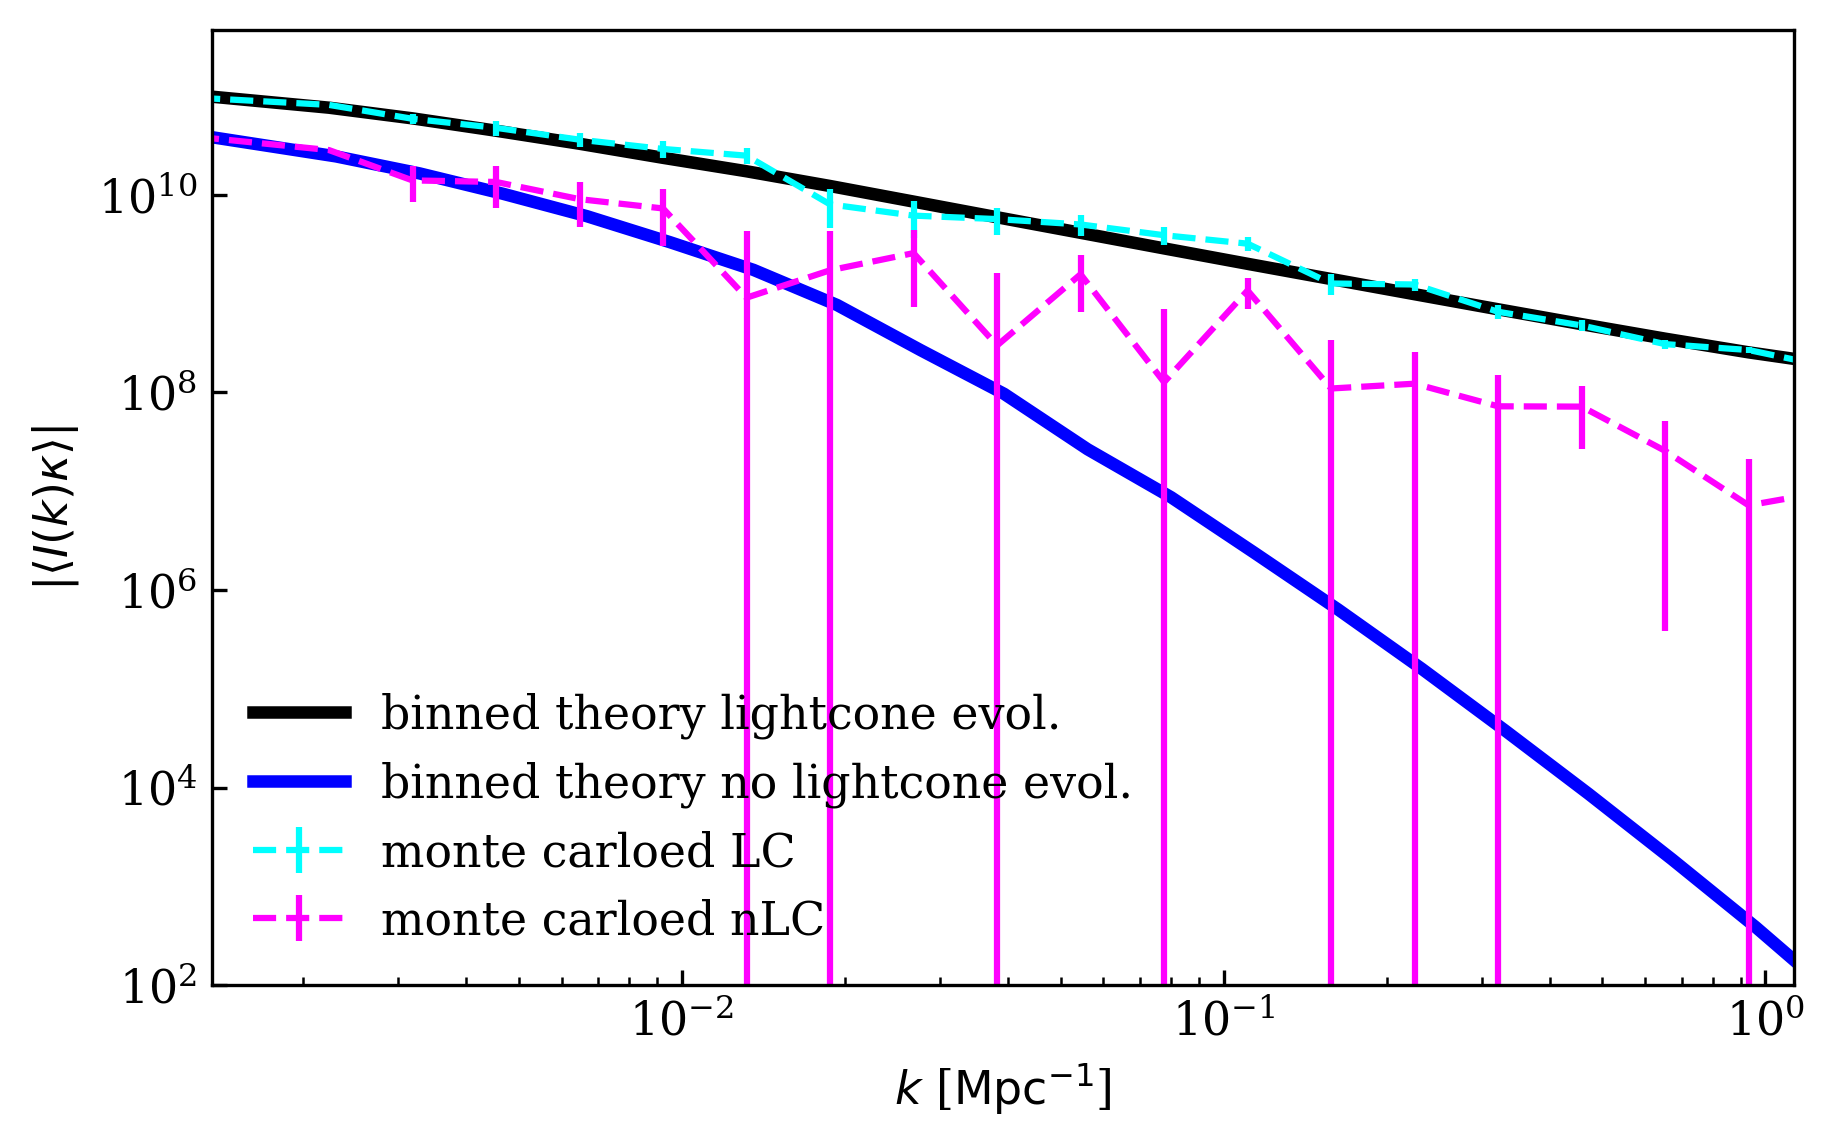

In [37]:
plt.figure(figsize=(6,6/1.618), dpi=300)


plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa), label='binned theory lightcone evol.', c='k', lw=3)
plt.plot(k_bin_centers*jnp.exp(0.03), jnp.abs(binned_Ik_kappa_noLC), label='binned theory no lightcone evol.', c='b', lw=3)


color = {'LC': 'cyan', 'nLC':'magenta'}
for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra[_type+'_binnedIk'])


    #I think this is a good estimate of the errorbar
    curr_mse = jnp.real(measured_spectra[_type+'_Ik_MSE'])/n_runs/(n_runs-1)
    def bin_MSE(bin_idx):
        mask = bin_indices == bin_idx
        #add in quadrature
        return jnp.sum(jnp.where(mask, curr_mse, 0.0))/jnp.sum(mask)/(jnp.sum(mask)-1)

    binned_rmse = jnp.sqrt(jax.vmap(bin_MSE)(jnp.arange(n_k_bins)))

    offset = 1
    # if(_type == 'nLC'):
    #     offset = jnp.exp(0.03) 

    plt.errorbar(k_bin_centers*offset, curr_spectra, yerr=jnp.real(binned_rmse),
                 label='monte carloed %s'%_type, ls='--', c=color[_type])


plt.legend(frameon=False)
plt.xlim(6*jnp.pi/L, jnp.pi/dchi/2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e2, None)
plt.xlabel(r'$k$ [${\sf Mpc}^{-1}$]')
plt.ylabel(r'$|\langle I(k)\kappa\rangle$|')
plt.savefig('figures/tmp_015.002_spectra.%d.pdf'%(n_runs), bbox_inches = 'tight')

In [38]:
estimated_II = measured_spectra['LC_II']/n_runs
estimated_cov = estimated_kk * estimated_II + estimated_Ik.reshape(-1, 1) * jnp.conj(estimated_Ik.reshape(1, -1))

@jax.jit
def bin_cov(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, estimated_cov, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
measured_spectra['LC_binned_cov']  = jax.vmap(jax.vmap(bin_cov, 
                                                          in_axes=(None, 0)), 
                                                 in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))

In [39]:
estimated_II_noLC = measured_spectra['nLC_II']/n_runs
estimated_cov_noLC = estimated_kk * estimated_II_noLC + estimated_Ik_noLC.reshape(-1, 1) * jnp.conj(estimated_Ik_noLC.reshape(1, -1))

@jax.jit
def bin_cov_noLC(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, estimated_cov_noLC, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
measured_spectra['nLC_binned_cov']  = jax.vmap(jax.vmap(bin_cov_noLC, 
                                                          in_axes=(None, 0)), 
                                                 in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))

In [40]:
import pickle
with open(oup_mc_fname, 'wb') as f:
    pickle.dump(measured_spectra, f)

# estimated SNR

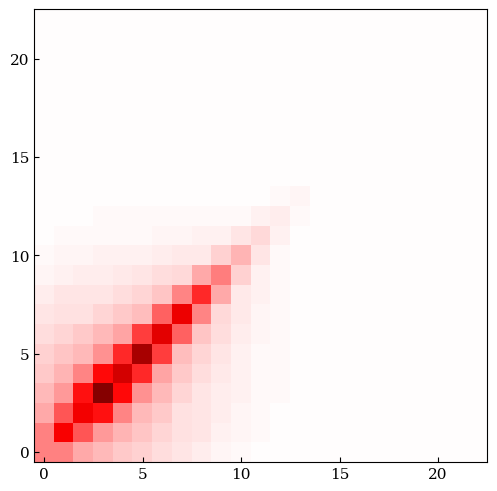

In [41]:
plt.imshow(jnp.abs(measured_spectra['LC_binned_cov']), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',)

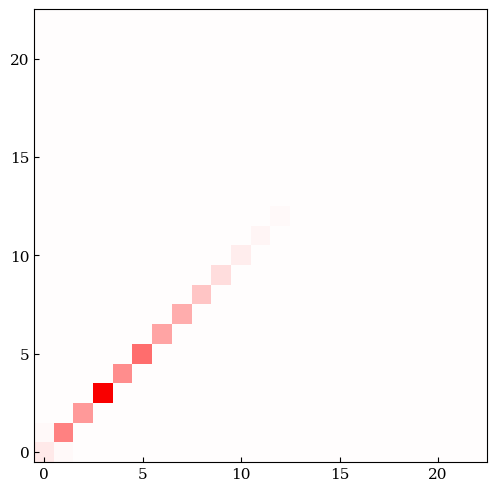

In [42]:
plt.imshow(jnp.abs(measured_spectra['nLC_binned_cov']), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',)

(0.0, 0.1)

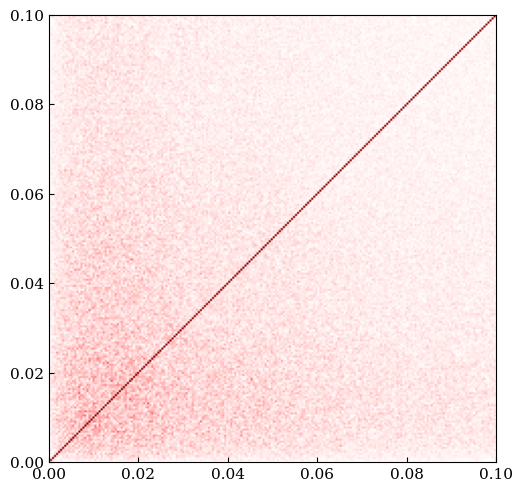

In [43]:
plt.imshow(jnp.abs(estimated_II_noLC[sort_idx][:,sort_idx]), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',
          extent=[min(ks), max(ks), min(ks), max(ks)])
plt.xlim(0, 1e-1)
plt.ylim(0, 1e-1)

(0.0, 0.1)

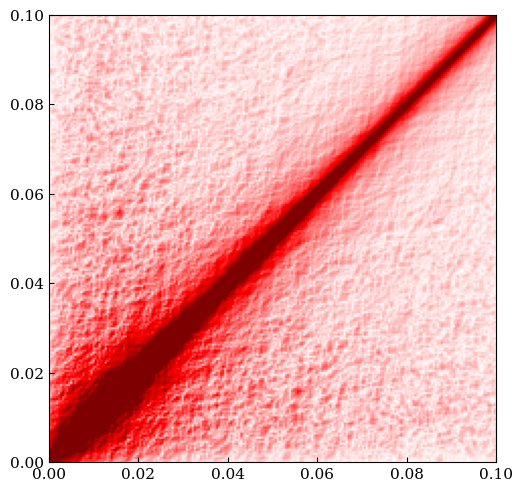

In [44]:
plt.imshow(jnp.abs(estimated_II[sort_idx][:,sort_idx]), origin='lower',
          vmin = -vb, vmax=vb, cmap='seismic',
          extent=[min(ks), max(ks), min(ks), max(ks)])
plt.xlim(0, 1e-1)
plt.ylim(0, 1e-1)

In [45]:
_binned_cov = np.array(measured_spectra['LC_binned_cov'])
estimated_SNR2s = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['LC_binnedIk'][kill_idx:]))
    estimated_SNR2s[kill_idx] = jnp.real(measured_spectra['LC_binnedIk'][kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 442.48it/s]


In [46]:
_binned_cov = np.array(measured_spectra['nLC_binned_cov'])
estimated_SNR2s_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['nLC_binnedIk'][kill_idx:]))
    estimated_SNR2s_noLC[kill_idx] = jnp.real(measured_spectra['nLC_binnedIk'][kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 607.30it/s]


In [47]:
_binned_cov = np.array(binned_cov)
estimated_SNR2s_hybrid = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['LC_binnedIk'][kill_idx:]))
    estimated_SNR2s_hybrid[kill_idx] = jnp.real(measured_spectra['LC_binnedIk'][kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 510.73it/s]


In [48]:
_binned_cov = np.array(binned_cov_noLC)
estimated_SNR2s_hybrid_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['nLC_binnedIk'][kill_idx:]))
    estimated_SNR2s_hybrid_noLC[kill_idx] = jnp.real(measured_spectra['nLC_binnedIk'][kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 774.89it/s]


# plot everything

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


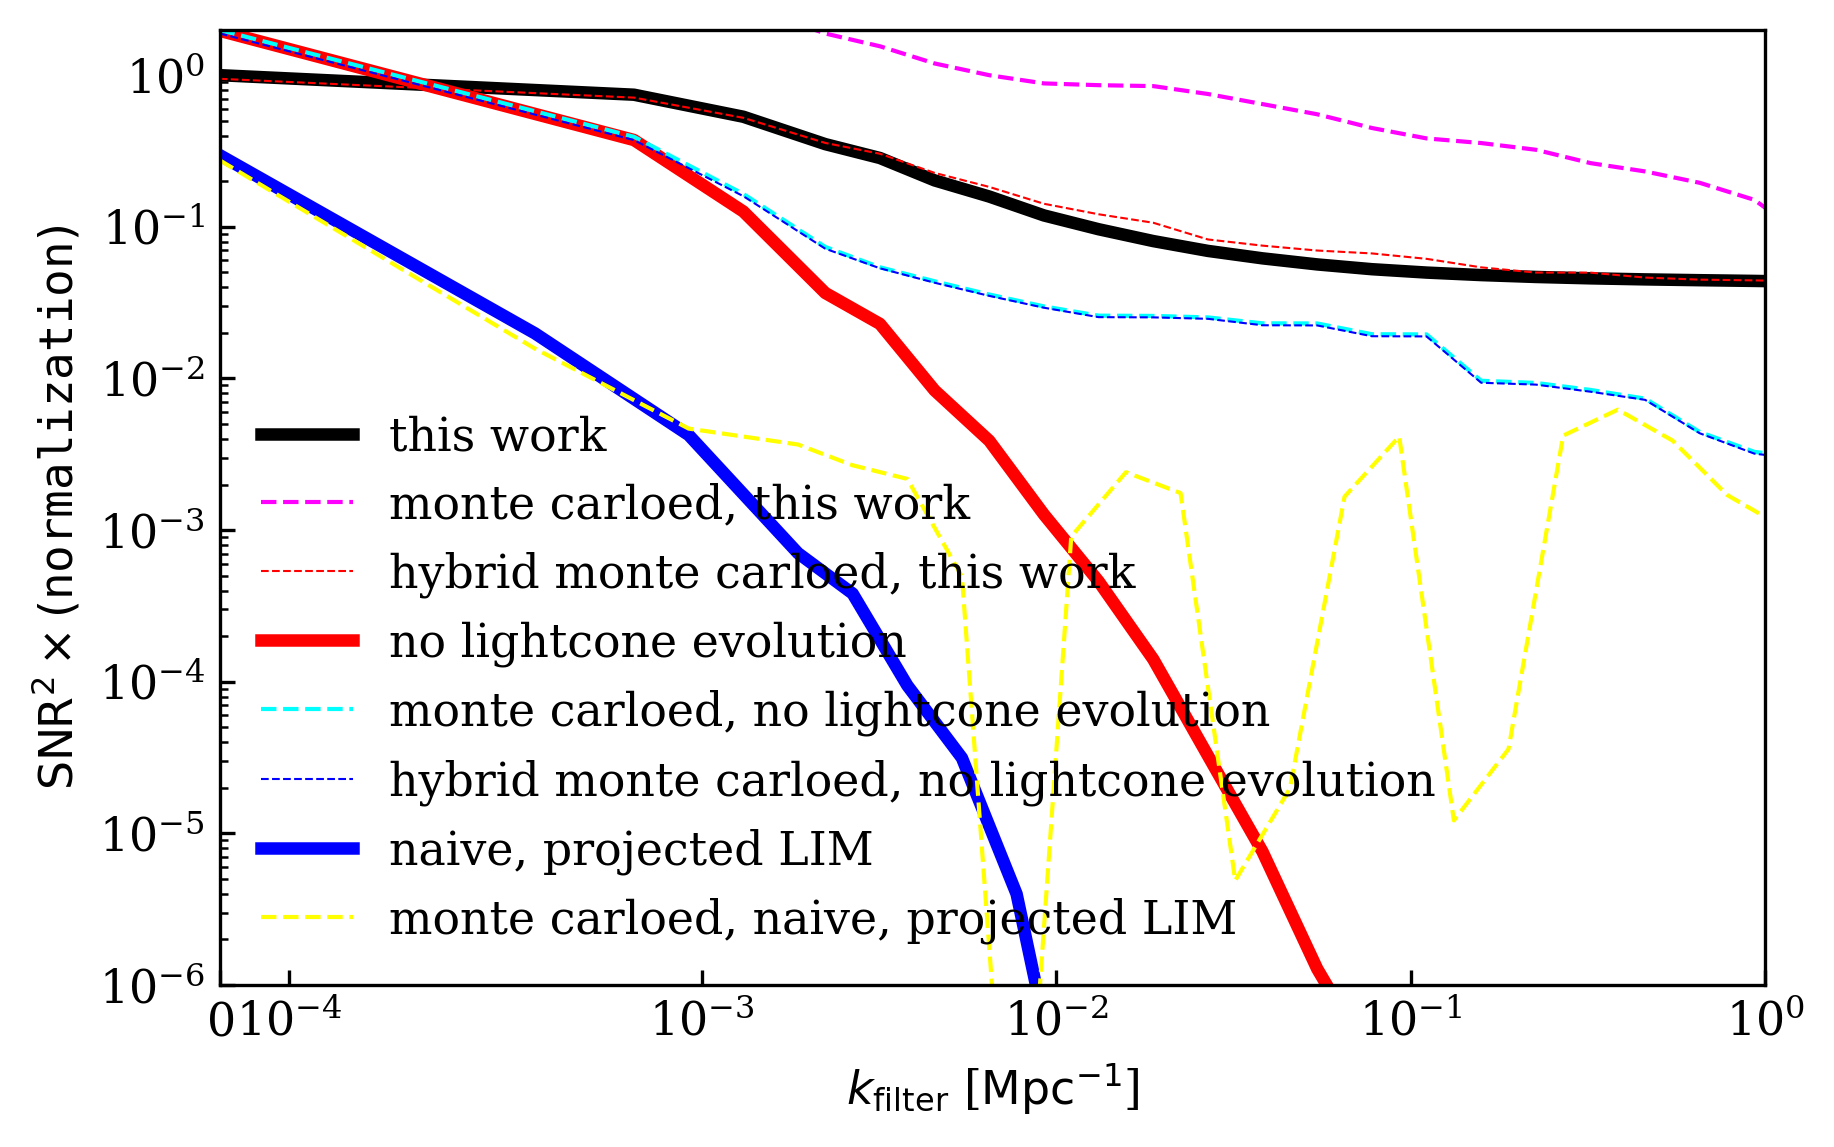

In [73]:
plt.figure(dpi = 300, figsize=(6, 6/1.618), facecolor='w')

def _plot(x, y, **params):
    plt.plot(x, y/SNR2s[0], **params)


_plot(k_bin_centers, SNR2s, c='k',  label='this work', lw=3)
_plot(k_bin_centers, estimated_SNR2s, 
         c='magenta', lw=1, ls='--',label='monte carloed, this work')
_plot(k_bin_centers, estimated_SNR2s_hybrid, 
         c='red', lw=0.5, ls='--',label='hybrid monte carloed, this work')

_plot(k_bin_centers, SNR2s_noLC, c='r', label='no lightcone evolution', lw=3)
_plot(k_bin_centers, estimated_SNR2s_noLC, 
         c='cyan', lw=1, ls='--', label='monte carloed, no lightcone evolution')
_plot(k_bin_centers, estimated_SNR2s_hybrid_noLC, 
         c='blue', lw=0.5, ls='--', label='hybrid monte carloed, no lightcone evolution')


_plot(Lambdas, SNR2s_proj, c='b', label='naive, projected LIM', lw=3)
_plot(Lambdas, jnp.real(estimated_Ik_proj)**2/estimated_var_proj, 
         c='yellow', lw=1, ls='--',label='monte carloed, naive, projected LIM')


plt.xscale('symlog', linthresh=2.5*jnp.pi/L)
plt.xlim(0, 1e0)
plt.yscale('log')

plt.legend(frameon=False)
plt.ylim(1e-6,2e0)

plt.ylabel(r'${\sf SNR}^2\times ({\tt normalization})$')
plt.xlabel(r'$k_{\sf filter}$ [${\sf Mpc}^{-1}$]')
plt.savefig('figures/tmp_015.002_SNR.%d.pdf'%(n_runs), bbox_inches = 'tight')